In [4]:
import numpy as np
from math import *
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec
from matplotlib.patches import ConnectionPatch

In [2]:
rsm = fits.open('./data/RSM20240501T064251_0024_HA.fits')
print(rsm[1].data.shape)
hacore = rsm[1].data[68, :, :]
hawing = rsm[1].data[-10, :, :]

(118, 2313, 2304)


In [3]:
central_spec = rsm[1].data[:, 1800:1900,950:1050].mean((1, 2))
print(central_spec)

[1140.3068 1120.0739 1082.6086 1038.5434 1035.3532 1054.5805 1084.8685
 1103.7293 1109.1185 1112.085  1114.2174 1113.6021 1110.4147 1106.6226
 1101.9663 1096.5997 1092.4714 1088.39   1082.8906 1077.1568 1072.268
 1063.4864 1039.231  1001.7809  976.4754  976.9677  998.3917 1022.3645
 1035.7565 1038.0631 1038.3175 1037.6276 1033.8752 1028.6962 1023.6674
 1018.3819 1012.7437 1006.7669 1000.3628  993.8482  987.5019  981.472
  975.035   968.0763  960.236   951.7106  942.3727  932.4957  922.6253
  912.1187  900.2416  886.4051  870.6336  852.4856  830.5964  801.9895
  763.1632  715.9742  661.3589  599.9847  537.3204  476.0063  419.247
  371.3467  335.0326  308.7413  289.7102  276.1835  266.0573  259.0533
  255.3395  254.5163  255.8741  259.4294  266.7356  279.1407  297.6194
  323.0871  356.7211  401.3702  457.089   518.7179  581.735   643.2488
  700.5047  750.6462  793.5676  828.2766  853.8364  873.6213  889.7448
  902.5258  912.5557  920.7653  927.4443  933.9409  941.5447  949.551
  957.5055

In [4]:
def gaussian(lx, *param):
    return param[0] * e ** (-(lx - param[1]) ** 2 / param[2] ** 2) + param[3]

def gaussian2(lx, *param):
    return param[0] * e ** (-(lx - param[1]) ** 2 / param[2] ** 2) + \
           param[3] * e ** (-(lx - param[4]) ** 2 / param[5] ** 2) + param[6]

def gaussfit(lx, ly, draw = 0, p0 = [1, 1, 1, 1], component = 1):
    if component == 1:
        para, pcov = curve_fit(gaussian, lx, ly, p0, method = 'lm')
        # pcov is covariance matrix
        if draw != 0:
            fitted = [para[0] * np.e ** (-(xi - para[1]) ** 2 / para[2] ** 2) + para[3] for xi in lx]
    if component == 2:
        para, pcov = curve_fit(gaussian2, lx, ly, p0, method = 'lm')
        # pcov is covariance matrix
        if draw != 0:
            fitted = [para[0] * np.e ** (-(xi - para[1]) ** 2 / para[2] ** 2) + \
                      para[3] * np.e ** (-(xi - para[4]) ** 2 / para[5] ** 2) + para[6] for xi in lx]
    if draw != 0:
        plt.subplot(211)
        plt.plot(lx, ly, 'b+:', label = 'data')
        plt.plot(lx, fitted, 'ro:', label = 'fit')
        plt.grid()
        plt.legend()
        plt.subplot(212)
        l0 = []
        lr = []
        for i in range(len(lx)):
            l0.append(0)
            lr.append(fitted[i] - ly[i])
        plt.plot(lx, l0, 'blue', linewidth = 2)
        plt.scatter(lx, lr, color = 'red')
        plt.grid()
    return(para, pcov)

In [5]:
def pearson(vector1, vector2):
    # should have len(vector1) == len(vector2)
    n = len(vector1)

    sum1 = sum(vector1)
    sum2 = sum(vector2)

    sum1_pow = sum([pow(v, 2.0) for v in vector1])
    sum2_pow = sum([pow(v, 2.0) for v in vector2])

    p_sum = sum([vector1[i] * vector2[i] for i in range(n)])

    num = p_sum - (sum1 * sum2 / n)
    den = sqrt((sum1_pow - pow(sum1, 2) / n) * (sum2_pow - pow(sum2, 2) / n))
    if den == 0:
        return 0.0
    return num / den

def polyfit_p(x, y, n, draw = 0):
    # return para: a0, a1, a2, ..., an for y = a0 + a1 * x + a2 * x ** 2 + ... + an * x ** n
    pfpara, pfcov = np.polyfit(x, y, n, cov = True)

    if draw != 0:
        plt.subplot(211)
        lx2 = x
        ly2 = []
        for i in range(len(lx2)):
            y2 = 0
            for j in range(len(pfpara)):
                y2 += pfpara[-j - 1] * lx2[i] ** j
            ly2.append(y2)
        plt.plot(x, y, 'ro', lx2, ly2, 'b', linewidth = 2)
        plt.grid()

        plt.subplot(212)
        l0 = []
        lr = []
        for i in range(len(lx2)):
            l0.append(0)
            lr.append(y[i] - ly2[i])
        plt.plot(x, l0, 'black', linewidth = 2)
        plt.scatter(x, lr, color = 'red')
        plt.grid()

    para = list(pfpara)
    para = para[::-1]

    mat_cov = []
    for i in range(len(pfcov)):
        mat_cov.append(pfcov[-i - 1][-i - 1])

    return para, mat_cov

In [25]:
def get_dplv(i,j):
    is_all_zero = np.all(rsm[1].data[68,i,j] == 0)
    if is_all_zero == True :
        return 0
    else:
        ij_spec = rsm[1].data[50:90, i, j]
        dict_c = {}
        for lag in range(-11, 10):
                ha_profilel = central_spec[lag + 50:lag + 90] # move the ha profile, but keep the length
                pr = pearson(ha_profilel, ij_spec)
                dict_c[-lag] = pr

        # use cubic fit to get the lag of the largest pearson correlation
        lag_max = max(dict_c, key = lambda x:dict_c[x])
        l_lag = [lag_max - k for k in range(-2, 3)]
        for k in l_lag:
                if(k<=-11 or k>=11):
                    return i,j
                else :
                    l_pr = []
                    l_pr.append(dict_c[k])

        para_cf, pcov_cf = polyfit_p(l_lag, l_pr, 3)

        a0, a1, a2, a3 = para_cf[0], para_cf[1], para_cf[2], para_cf[3] # in format of a0 + a1 * x  + a2 * x ** 2 + a3 * x ** 3
        s0, s1, s2, s3 = pcov_cf[0], pcov_cf[1], pcov_cf[2], pcov_cf[3]

        dcf01 = (-2 * a2 + sqrt((2 * a2) ** 2 - 12 * a1 * a3)) / (6 * a3)
        dcf02 = (-2 * a2 - sqrt((2 * a2) ** 2 - 12 * a1 * a3)) / (6 * a3)

        d2cf1 = 6 * a3 * dcf01 + 2 * a2
        d2cf2 = 6 * a3 * dcf02 + 2 * a2

        covcf1_2 = s1 * (1 / ((2 * a2) ** 2 - 12 * a1 * a3)) + \
        s2 * (-1 / (3 * a3) + 2 * a2 / (3 * a3 * sqrt((2 * a2) ** 2 - 12 * a1 * a3))) ** 2 + \
        s3 * (a2 / (3 * a3 ** 2) - (1 / (6 * a3 ** 2)) * (6 * a1 * a3 / sqrt((2 * a2) ** 2 - 12 * a1 * a3) + \
        sqrt((2 * a2) ** 2 - 12 * a1 * a3))) ** 2
        covcf2_2 = s1 * (1 / ((2 * a2) ** 2 - 12 * a1 * a3)) + \
        s2 * (-1 / (3 * a3) - 2 * a2 / (3 * a3 * sqrt((2 * a2) ** 2 - 12 * a1 * a3))) ** 2 + \
        s3 * (a2 / (3 * a3 ** 2) + (1 / (6 * a3 ** 2)) * (6 * a1 * a3 / sqrt((2 * a2) ** 2 - 12 * a1 * a3) + \
        sqrt((2 * a2) ** 2 - 12 * a1 * a3))) ** 2

        if d2cf1 < 0:
            cal_shift_cf = dcf01
            cal_stddev_cf = sqrt(covcf1_2)
        else:
            cal_shift_cf = dcf02
            cal_stddev_cf = sqrt(covcf2_2)
            
        return cal_shift_cf * 1.1068


print(get_dplv(2000,2000))

       

0


In [ ]:
print(rsm[1].data.shape[2])

2304


非零元素的行索引范围: 0 到 2312
非零元素的列索引范围: 0 到 2303


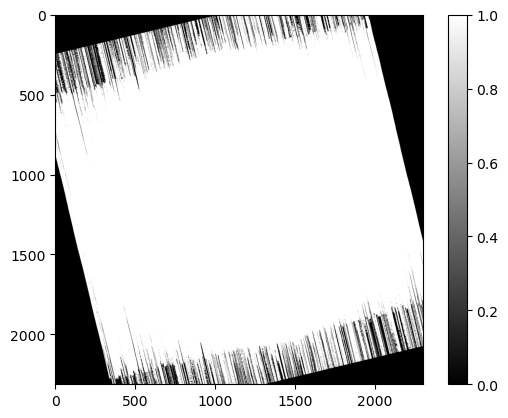

5329152


In [ ]:
nonzero_mask = rsm[1].data[68,:,:] != 0
nonzero_indices = np.where(nonzero_mask)
nonzero_rows, nonzero_cols = np.where(nonzero_mask)
nonzero_coordinates = list(zip(nonzero_rows, nonzero_cols))
min_row = np.min(nonzero_rows)
max_row = np.max(nonzero_rows)
min_col = np.min(nonzero_cols)
max_col = np.max(nonzero_cols)
min_row, max_row = nonzero_indices[0].min(), nonzero_indices[0].max()
min_col, max_col = nonzero_indices[1].min(), nonzero_indices[1].max()
print(f"非零元素的行索引范围: {min_row} 到 {max_row}")
print(f"非零元素的列索引范围: {min_col} 到 {max_col}")
print(f"行坐标（x坐标）的最小值和最大值: {min_row} 和 {max_row}")
print(f"列坐标（y坐标）的最小值和最大值: {min_col} 和 {max_col}")

print(np.size(nonzero_coordinates))
plt.imshow(nonzero_mask, cmap='gray')  # 使用灰度色图显示非零值
plt.colorbar()  # 显示颜色条
plt.show()
print(np.size(nonzero_mask))

In [ ]:
# 假设 rsm[1].data[68, :, :] 是你的二维数组
# 创建一个布尔掩码，找出所有非零元素
nonzero_mask = rsm[1].data[68, :, :] != 0

# 使用 np.where 找到非零元素的索引
nonzero_rows, nonzero_cols = np.where(nonzero_mask)

# 如果你想要将这些坐标保存到一个列表中
nonzero_coordinates = list(zip(nonzero_rows, nonzero_cols))

# 获取非零元素的行索引范围（x坐标的最大值和最小值）
min_row = np.min(nonzero_rows)
max_row = np.max(nonzero_rows)

# 获取非零元素的列索引范围（y坐标的最大值和最小值）
min_col = np.min(nonzero_cols)
max_col = np.max(nonzero_cols)

# 打印结果
print(f"行坐标（x坐标）的最小值和最大值: {min_row} 和 {max_row}")
print(f"列坐标（y坐标）的最小值和最大值: {min_col} 和 {max_col}")

print(np.size(nonzero_coordinates))

行坐标（x坐标）的最小值和最大值: 0 和 2312
列坐标（y坐标）的最小值和最大值: 0 和 2303
8616662



In [20]:
print(rsm[1].data[50:90,1000,1000])

[1020 1006  991  973  948  919  880  831  769  692  610  534  464  404
  357  322  296  277  264  253  246  243  244  249  259  278  304  340
  388  452  527  605  685  761  828  878  915  945  967  987]


100   100 

100   200 

100   300 

100   400 

100   500 

100   600 

100   700 

100   800 

100   900 

100   1000 

100   1100 

100   1200 

100   1300 

100   1400 

100   1500 

100   1600 

100   1700 

100   1800 

100   1900 

200   100 

200   200 

200   300 

200   400 

200   500 

200   600 

200   700 

200   800 

200   900 

200   1000 

200   1100 

200   1200 

200   1300 

200   1400 

200   1500 

200   1600 

200   1700 

200   1800 

200   1900 

300   100 

300   200 

300   300 

300   400 

300   500 

300   600 

300   700 

300   800 

300   900 

300   1000 

300   1100 

300   1200 

300   1300 

300   1400 

300   1500 

300   1600 

300   1700 

300   1800 

300   1900 

400   100 

400   200 

400   300 

400   400 

400   500 

400   600 

400   700 

400   800 

400   900 

400   1000 

400   1100 

400   1200 

400   1300 

400   1400 

400   1500 

400   1600 

400   1700 

400   1800 

400   1900 

500   100 

500   200 

500   300 

500   400 



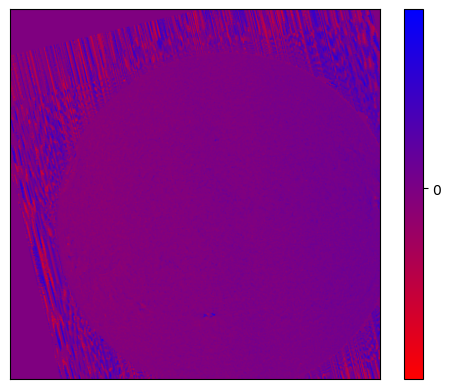

In [27]:
import numpy as np
from math import sqrt
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec
from scipy.interpolate import interp1d
from matplotlib.patches import ConnectionPatch

rsm = fits.open('./data/RSM20240501T064251_0024_HA.fits')

central_spec = rsm[1].data[:, 1800:1900,950:1050].mean((1, 2))

def pearson(vector1, vector2):
    # should have len(vector1) == len(vector2)
    n = len(vector1)

    sum1 = sum(vector1)
    sum2 = sum(vector2)

    sum1_pow = sum([pow(v, 2.0) for v in vector1])
    sum2_pow = sum([pow(v, 2.0) for v in vector2])

    p_sum = sum([vector1[i] * vector2[i] for i in range(n)])

    num = p_sum - (sum1 * sum2 / n)
    den = sqrt((sum1_pow - pow(sum1, 2) / n) * (sum2_pow - pow(sum2, 2) / n))
    if den == 0:
        return 0.0
    return num / den

def polyfit_p(x, y, n, draw = 0):
    # return para: a0, a1, a2, ..., an for y = a0 + a1 * x + a2 * x ** 2 + ... + an * x ** n
    pfpara, pfcov = np.polyfit(x, y, n, cov = True)

    if draw != 0:
        plt.subplot(211)
        lx2 = x
        ly2 = []
        for i in range(len(lx2)):
            y2 = 0
            for j in range(len(pfpara)):
                y2 += pfpara[-j - 1] * lx2[i] ** j
            ly2.append(y2)
        plt.plot(x, y, 'ro', lx2, ly2, 'b', linewidth = 2)
        plt.grid()

        plt.subplot(212)
        l0 = []
        lr = []
        for i in range(len(lx2)):
            l0.append(0)
            lr.append(y[i] - ly2[i])
        plt.plot(x, l0, 'black', linewidth = 2)
        plt.scatter(x, lr, color = 'red')
        plt.grid()

    para = list(pfpara)
    para = para[::-1]

    mat_cov = []
    for i in range(len(pfcov)):
        mat_cov.append(pfcov[-i - 1][-i - 1])

    return para, mat_cov

def get_dplv(i,j):
    ij_spec = rsm[1].data[50:90,i,j]
    dict_c = {}
    for lag in range(-10, 11):
        ha_profilel = central_spec[lag + 50:lag + 90] # move the ha profile, but keep the length
        pr = pearson(ha_profilel, ij_spec)
        dict_c[-lag] = pr
    if(i%100==0 and j %100 ==0):
        print(i,' ',j,'\n')
    # use cubic fit to get the lag of the largest pearson correlation
    lag_max = max(dict_c, key = lambda x:dict_c[x])
    l_lag = [lag_max - k for k in range(-2, 3)]
    l_pr=[]
    for k in l_lag:
        if k<=-11 or k>=11:
            return 0
        else:
            l_pr.append(dict_c[k])
    para_cf, pcov_cf = polyfit_p(l_lag, l_pr, 3)
    a0, a1, a2, a3 = para_cf[0], para_cf[1], para_cf[2], para_cf[3] # in format of a0 + a1 * x  + a2 * x ** 2 + a3 * x ** 3
    s0, s1, s2, s3 = pcov_cf[0], pcov_cf[1], pcov_cf[2], pcov_cf[3]

    dcf01 = (-2 * a2 + sqrt((2 * a2) ** 2 - 12 * a1 * a3)) / (6 * a3)
    dcf02 = (-2 * a2 - sqrt((2 * a2) ** 2 - 12 * a1 * a3)) / (6 * a3)

    d2cf1 = 6 * a3 * dcf01 + 2 * a2
    d2cf2 = 6 * a3 * dcf02 + 2 * a2
    covcf1_2 = s1 * (1 / ((2 * a2) ** 2 - 12 * a1 * a3)) + \
    s2 * (-1 / (3 * a3) + 2 * a2 / (3 * a3 * sqrt((2 * a2) ** 2 - 12 * a1 * a3))) ** 2 + \
    s3 * (a2 / (3 * a3 ** 2) - (1 / (6 * a3 ** 2)) * (6 * a1 * a3 / sqrt((2 * a2) ** 2 - 12 * a1 * a3) + \
    sqrt((2 * a2) ** 2 - 12 * a1 * a3))) ** 2
    covcf2_2 = s1 * (1 / ((2 * a2) ** 2 - 12 * a1 * a3)) + \
    s2 * (-1 / (3 * a3) - 2 * a2 / (3 * a3 * sqrt((2 * a2) ** 2 - 12 * a1 * a3))) ** 2 + \
    s3 * (a2 / (3 * a3 ** 2) + (1 / (6 * a3 ** 2)) * (6 * a1 * a3 / sqrt((2 * a2) ** 2 - 12 * a1 * a3) + \
    sqrt((2 * a2) ** 2 - 12 * a1 * a3))) ** 2

    if d2cf1 < 0:
        cal_shift_cf = dcf01
        cal_stddev_cf = sqrt(covcf1_2)
    else:
        cal_shift_cf = dcf02
        cal_stddev_cf = sqrt(covcf2_2)

    is_all_zero = np.all(np.equal(rsm[1].data[50:90,i,j], 0))
    if is_all_zero == 0:
        return cal_shift_cf * 1.1068
    else:
        return 0
    
#创造一个从红到蓝的颜色条
# 定义颜色段的起始和结束颜色
red = (1, 0, 0, 1)  # 红色，不透明
blue = (0, 0, 1, 1)  # 蓝色，不透明

# 创建颜色列表，这里只定义了两个颜色段：从红色到蓝色
colors = [red, blue]

# 使用分段函数创建colormap
rtb_cmap = mcolors.LinearSegmentedColormap.from_list('red_to_blue', colors)

# 创建一个空矩阵
rows, cols = 2300, 2300  # 例如，10行5列
matrix=np.zeros((rows,cols))


for i in range (rows):
    for j in range (cols):
        matrix[i,j] = get_dplv(i,j)

normalized_matrix = (matrix - np.mean(matrix)) / (matrix.max() - matrix.min())

# 使用imshow函数绘制图像
plt.imshow(normalized_matrix, cmap=rtb_cmap)
plt.xticks([])
plt.yticks([])

# 显示颜色条
plt.colorbar(ticks=[-1,0,1])

# 显示图像
plt.show()

In [4]:
import numpy as np
from math import *
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec
from scipy.interpolate import interp1d

rsm = fits.open('./fits/RSM20240501T064251_0024_HA.fits')

central_spec = rsm[1].data[:, 1800:1900,950:1050].mean((1, 2))

def pearson(vector1, vector2):
    # should have len(vector1) == len(vector2)
    n = len(vector1)

    sum1 = sum(vector1)
    sum2 = sum(vector2)

    sum1_pow = sum([pow(v, 2.0) for v in vector1])
    sum2_pow = sum([pow(v, 2.0) for v in vector2])

    p_sum = sum([vector1[i] * vector2[i] for i in range(n)])

    num = p_sum - (sum1 * sum2 / n)
    den = sqrt((sum1_pow - pow(sum1, 2) / n) * (sum2_pow - pow(sum2, 2) / n))
    if den == 0:
        return 0.0
    return num / den

def polyfit_p(x, y, n, draw = 0):
    # return para: a0, a1, a2, ..., an for y = a0 + a1 * x + a2 * x ** 2 + ... + an * x ** n
    pfpara, pfcov = np.polyfit(x, y, n, cov = True)

    if draw != 0:
        plt.subplot(211)
        lx2 = x
        ly2 = []
        for i in range(len(lx2)):
            y2 = 0
            for j in range(len(pfpara)):
                y2 += pfpara[-j - 1] * lx2[i] ** j
            ly2.append(y2)
        plt.plot(x, y, 'ro', lx2, ly2, 'b', linewidth = 2)
        plt.grid()

        plt.subplot(212)
        l0 = []
        lr = []
        for i in range(len(lx2)):
            l0.append(0)
            lr.append(y[i] - ly2[i])
        plt.plot(x, l0, 'black', linewidth = 2)
        plt.scatter(x, lr, color = 'red')
        plt.grid()

    para = list(pfpara)
    para = para[::-1]

    mat_cov = []
    for i in range(len(pfcov)):
        mat_cov.append(pfcov[-i - 1][-i - 1])

    return para, mat_cov

def get_dplv(i,j):
    ij_spec = rsm[1].data[50:90,i,j]
    dict_c = {}
    for lag in range(-10, 11):
        ha_profilel = central_spec[lag + 50:lag + 90] # move the ha profile, but keep the length
        pr = pearson(ha_profilel, ij_spec)
        dict_c[-lag] = pr

    if(i%100==0 and j %100 ==0):
        print(i,' ',j,'\n')
    
    # use cubic fit to get the lag of the largest pearson correlation
    lag_max = max(dict_c, key = lambda x:dict_c[x])
    l_lag = [lag_max - k for k in range(-2, 3)]

    l_pr=[]
    for k in l_lag:
        if k<=-11 or k>=11:
            return 0
        else:
            l_pr.append(dict_c[k])

    para_cf, pcov_cf = polyfit_p(l_lag, l_pr, 3)

    a0, a1, a2, a3 = para_cf[0], para_cf[1], para_cf[2], para_cf[3] # in format of a0 + a1 * x  + a2 * x ** 2 + a3 * x ** 3
    s0, s1, s2, s3 = pcov_cf[0], pcov_cf[1], pcov_cf[2], pcov_cf[3]

    dcf01 = (-2 * a2 + sqrt((2 * a2) ** 2 - 12 * a1 * a3)) / (6 * a3)
    dcf02 = (-2 * a2 - sqrt((2 * a2) ** 2 - 12 * a1 * a3)) / (6 * a3)

    d2cf1 = 6 * a3 * dcf01 + 2 * a2
    d2cf2 = 6 * a3 * dcf02 + 2 * a2

    covcf1_2 = s1 * (1 / ((2 * a2) ** 2 - 12 * a1 * a3)) + \
    s2 * (-1 / (3 * a3) + 2 * a2 / (3 * a3 * sqrt((2 * a2) ** 2 - 12 * a1 * a3))) ** 2 + \
    s3 * (a2 / (3 * a3 ** 2) - (1 / (6 * a3 ** 2)) * (6 * a1 * a3 / sqrt((2 * a2) ** 2 - 12 * a1 * a3) + \
    sqrt((2 * a2) ** 2 - 12 * a1 * a3))) ** 2
    covcf2_2 = s1 * (1 / ((2 * a2) ** 2 - 12 * a1 * a3)) + \
    s2 * (-1 / (3 * a3) - 2 * a2 / (3 * a3 * sqrt((2 * a2) ** 2 - 12 * a1 * a3))) ** 2 + \
    s3 * (a2 / (3 * a3 ** 2) + (1 / (6 * a3 ** 2)) * (6 * a1 * a3 / sqrt((2 * a2) ** 2 - 12 * a1 * a3) + \
    sqrt((2 * a2) ** 2 - 12 * a1 * a3))) ** 2

    if d2cf1 < 0:
        cal_shift_cf = dcf01
        cal_stddev_cf = sqrt(covcf1_2)
    else:
        cal_shift_cf = dcf02
        cal_stddev_cf = sqrt(covcf2_2)

    is_all_zero = np.all(np.equal(rsm[1].data[50:90,i,j], 0))
    if is_all_zero == False:
        return cal_shift_cf * 1.1068
    else:
        return 0
    
#创造一个从红到蓝的颜色条
# 定义颜色段的起始和结束颜色
red = (1, 0, 0, 1)  # 红色，不透明
blue = (0, 0, 1, 1)  # 蓝色，不透明

colors = [red, blue]

# 使用分段函数创建colormap
rtb_cmap = mcolors.LinearSegmentedColormap.from_list('red_to_blue', colors)

# 创建一个空矩阵
rows, cols = 2300, 2300  # 例如，10行5列
matrix=np.zeros((rows,cols))

#找出所有非零元素
nonzero_mask = rsm[1].data[68, :, :] != 0
nonzero_rows, nonzero_cols = np.where(nonzero_mask)
nonzero_coordinates = list(zip(nonzero_rows, nonzero_cols))

#在非零元素中进行循环
for k in range(len(nonzero_coordinates)):
    i, j = nonzero_coordinates[k]
    if 0<=i<matrix.shape[0] and 0<=j<matrix.shape[1]:
        matrix[i,j]=get_dplv(i,j) 
    else:
        matrix[i,j]=0

#for i in range (1,2000):
    #for j in range (1,2000):
        #matrix[i,j] = get_dplv(i,j)

#归一化并调整对比度
normalized_matrix = (matrix - np.mean(matrix[900:1100,900:1100])) / (matrix.max() - matrix.min())
normalized_matrix[i,j] = normalized_matrix[i,j] ** 3

# 使用imshow函数绘制图像
plt.imshow(normalized_matrix, cmap=rtb_cmap)
plt.xticks([])
plt.yticks([])

# 显示颜色条
plt.colorbar(ticks=[-1,0.5,0,0.5,1])

# 显示图像
plt.show()

0   1100 

0   1200 

0   1300 

0   1800 

0   1900 

100   700 

100   900 

100   1100 

100   1300 

100   1400 

100   1500 

100   1700 

100   1800 

100   1900 

200   400 

200   500 

200   600 

200   800 

200   900 

200   1000 

200   1100 

200   1200 

200   1300 

200   1400 

200   1500 

200   1600 

200   1700 

200   1800 

200   1900 

200   2000 

300   100 

300   200 

300   300 

300   400 

300   500 

300   600 

300   700 

300   800 

300   900 

300   1000 

300   1100 

300   1200 

300   1300 

300   1400 

300   1500 

300   1600 

300   1700 

300   1800 

300   1900 

300   2000 

400   200 

400   400 

400   500 

400   600 

400   700 

400   800 

400   900 

400   1000 

400   1100 

400   1200 

400   1300 

400   1400 

400   1500 

400   1600 

400   1700 

400   1800 

400   1900 

400   2000 



KeyboardInterrupt: 

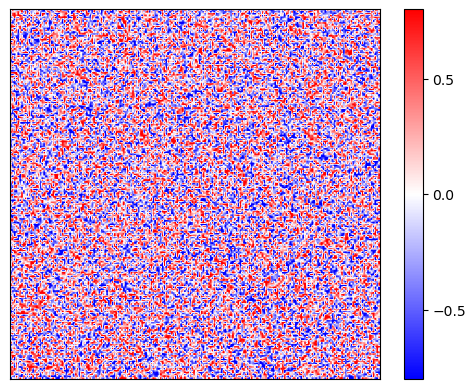

In [25]:
#创造一个从红到蓝的颜色条
# 定义颜色段的起始和结束颜色
red = (1, 0, 0, 1)  # 红色，不透明
blue = (0, 0, 1, 1)  # 蓝色，不透明
white = (1, 1, 1, 1)  # 白色，不透明

# 定义颜色列表和对应的数值
colors = [blue, white, red]

# 使用分段函数创建colormap
rtb_cmap = mcolors.LinearSegmentedColormap.from_list('blue_white_red', colors)

# 定义归一化的范围，使得-1对应蓝色，1对应红色，0对应白色
norm = mcolors.Normalize(vmin=-1, vmax=1)

# 使用imshow函数绘制图像
plt.imshow(np.random.uniform(low=-1, high=1, size=(200, 200)), cmap=rtb_cmap, clim=(-0.8,0.8),norm=norm)
plt.xticks([])
plt.yticks([])

# 显示颜色条
plt.colorbar(ticks=[-1,-0.5,0,0.5,1])

# 显示图像
plt.show()